In [50]:
# Importing modules
import pandas as pd
import re

# LDA Model
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import spacy
import itertools

# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

#plotting libraries!
import matplotlib.pyplot as plt
%matplotlib inline

# Import the wordcloud library
from wordcloud import WordCloud

In [51]:
movie_descrips_ratings = pd.read_csv('./ml_netflix.csv')

In [52]:
# get rid of redundancy from ratings
movies = movie_descrips_ratings.drop_duplicates('title')[['title', 'description', 'movieId', 'genres']]
movies

,title,description,movieId,genres
0,Grown Ups,Mourning the loss of their beloved junior high...,539,Comedy
10,Dark Skies,A family’s idyllic suburban life shatters when...,629,Horror|Sci-Fi|Thriller
12,Jaws,When an insatiable great white shark terrorize...,80,Action|Horror
103,Jaws 2,Four years after the last deadly shark attacks...,81,Horror|Thriller
120,Jaws: The Revenge,"After another deadly shark attack, Ellen Brody...",215,Horror|Thriller
...,...,...,...,...
14164,Young Adult,When a divorced writer gets a letter from an o...,592,Comedy|Drama
14166,"Yours, Mine and Ours",When a father of eight and a mother of 10 prep...,384,Comedy|Romance
14169,Zodiac,"A political cartoonist, a crime reporter and a...",415,Crime|Drama|Thriller
14207,Zombieland,Looking to survive in a world taken over by zo...,509,Action|Comedy|Horror


In [53]:
movie_descrips_ratings

,title,description,userId,rating,movieId,genres
0,Grown Ups,Mourning the loss of their beloved junior high...,20,2.0,539,Comedy
1,Grown Ups,Mourning the loss of their beloved junior high...,102,3.5,539,Comedy
2,Grown Ups,Mourning the loss of their beloved junior high...,110,5.0,539,Comedy
3,Grown Ups,Mourning the loss of their beloved junior high...,248,3.0,539,Comedy
4,Grown Ups,Mourning the loss of their beloved junior high...,296,2.5,539,Comedy
...,...,...,...,...,...,...
14256,Zombieland,Looking to survive in a world taken over by zo...,578,3.0,509,Action|Comedy|Horror
14257,Zombieland,Looking to survive in a world taken over by zo...,591,3.5,509,Action|Comedy|Horror
14258,Zombieland,Looking to survive in a world taken over by zo...,594,3.0,509,Action|Comedy|Horror
14259,Zombieland,Looking to survive in a world taken over by zo...,605,3.5,509,Action|Comedy|Horror


In [54]:
# # add genres to their descrips
# each_movies_genre = movies['genres'].str.split('|').str.join(' ')
# movies['description'] = movies['description'].str.cat(each_movies_genre, ' ')

In [55]:
movies['description'][0]

'Mourning the loss of their beloved junior high basketball coach, five middle-aged pals reunite at a lake house and rediscover the joys of being a kid. Comedy'

# Trying out Python LDA from [here](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) with preprocessing and K-picking from [here](https://github.com/nicoleeesim/content-based_movie_recommender)

In [56]:
# remove non-english words. Reference: https://datascience.stackexchange.com/questions/46705/to-remove-chinese-characters-as-features
movies['description'] = movies['description'].map(lambda x: re.sub("([^\x00-\x7F])+","", x))

In [57]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations and special characters

data_words = list(sent_to_words(movies['description']))

In [58]:
stop_words = stopwords.words('english')
# stop_words.extend(['']) #extend existing stop word list if needed
# print(stop_words)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [59]:
# Build the bigram 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [60]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [61]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['mourn', 'loss', 'beloved', 'junior', 'high', 'basketball', 'coach', 'middle', 'aged', 'pal', 'joy', 'kid', 'comedy']]


/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 

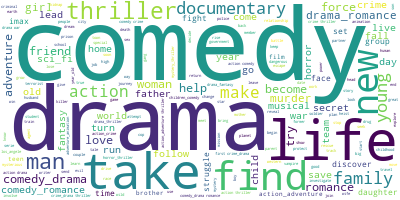

In [62]:
# Join the different processed titles together.
list_of_words = list(itertools.chain.from_iterable(data_lemmatized))
long_string = ','.join(word for word in list_of_words)
# long_string = ','.join(list(movies['descrips_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [63]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

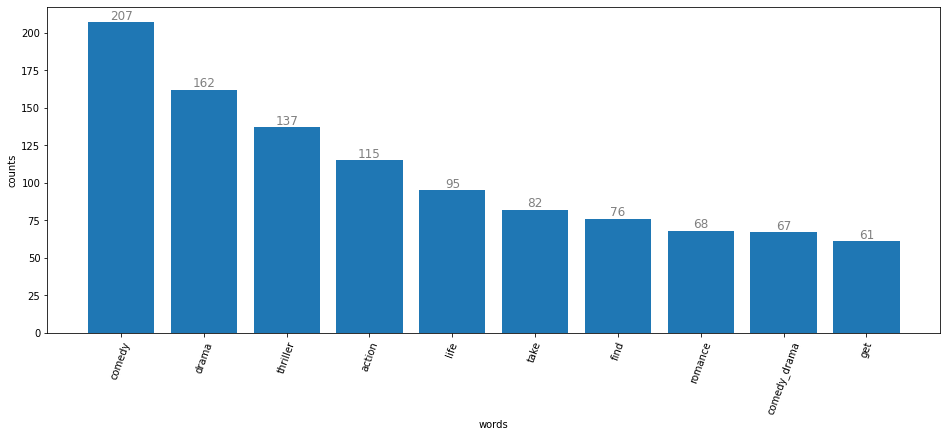

In [64]:
import operator


word_freq = []
word_list = []
count_dict = {}
for n in id2word.values():
    count_dict[n] = list_of_words.count(n)
sorted_dict = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)[0:10]

plt.figure(figsize=(16,6))
plt.bar(range(len(sorted_dict)), [val[1] for val in sorted_dict], align='center')
plt.xticks(range(len(sorted_dict)), [val[0] for val in sorted_dict])
plt.xticks(rotation=70)
plt.xlabel('words')
plt.ylabel('counts')

# setting data labels
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='grey', ha='center', va='bottom')
    
plt.show()

## Trying out LDA with random K

In [65]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [66]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"comedy" + 0.017*"find" + 0.017*"romance" + 0.016*"get" + '
  '0.016*"comedy_drama" + 0.015*"life" + 0.015*"drama" + 0.011*"thriller" + '
  '0.009*"sci_fi" + 0.009*"love"'),
 (1,
  '0.018*"comedy" + 0.016*"fantasy" + 0.015*"thriller" + 0.015*"drama" + '
  '0.014*"action_adventure" + 0.013*"musical" + 0.012*"action" + '
  '0.011*"sci_fi" + 0.010*"old" + 0.009*"street"'),
 (2,
  '0.025*"comedy" + 0.024*"crime" + 0.016*"drama" + 0.014*"drug" + 0.014*"go" '
  '+ 0.013*"western" + 0.012*"drama_thriller" + 0.012*"mother" + 0.009*"face" '
  '+ 0.009*"family"'),
 (3,
  '0.021*"drama" + 0.019*"comedy" + 0.018*"find" + 0.016*"world" + '
  '0.014*"work" + 0.013*"new" + 0.013*"take" + 0.012*"imax" + 0.011*"life" + '
  '0.011*"struggle"'),
 (4,
  '0.028*"thriller" + 0.021*"action" + 0.018*"take" + 0.016*"drama" + '
  '0.015*"life" + 0.013*"comedy" + 0.012*"team" + 0.011*"find" + '
  '0.008*"father" + 0.008*"story"'),
 (5,
  '0.021*"home" + 0.020*"drama" + 0.019*"romance" + 0.015*"thri

In [67]:
# Evaluate base model- Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.351042269090439


In [68]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [69]:
# Iterate over possible number of topics. takes about 2-3mins
topic_param = [1,5,10,15,20,25,30,35,40]
coherence_score = []

for k in topic_param:
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(cv)

param_tuning_coherence = pd.DataFrame()
param_tuning_coherence["topic_param"] = topic_param
param_tuning_coherence['coherence_score'] = coherence_score
param_tuning_coherence

,topic_param,coherence_score
0,1,0.327597
1,5,0.308271
2,10,0.337401
3,15,0.331031
4,20,0.324095
5,25,0.347560
6,30,0.327305
7,35,0.325374
8,40,0.321239


In [70]:
num_topics = param_tuning_coherence.iloc[param_tuning_coherence['coherence_score'].idxmax()]['topic_param']

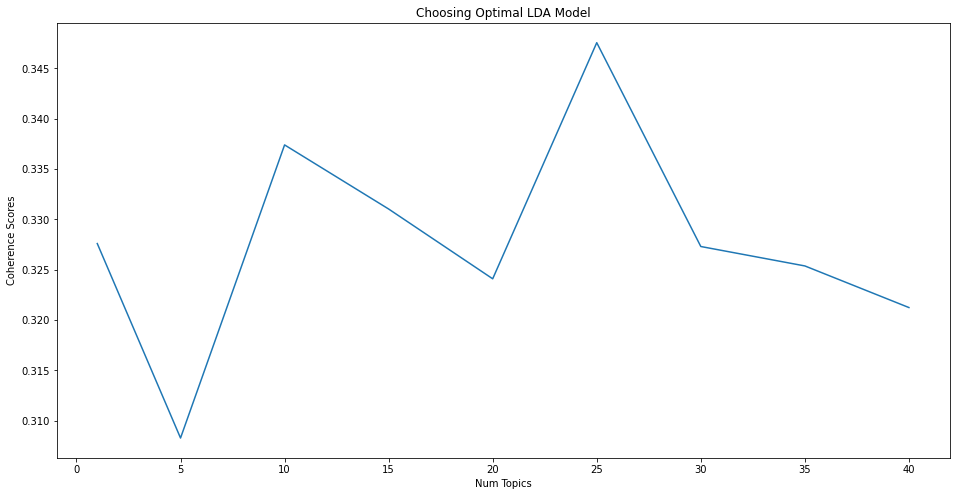

In [71]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, param_tuning_coherence['coherence_score'])

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

In [72]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [73]:
# Print the Keyword in the num_topics topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(17,
  '0.024*"comedy" + 0.021*"documentary" + 0.019*"new" + 0.017*"thriller" + '
  '0.015*"discover" + 0.014*"comedy_drama" + 0.013*"town" + 0.013*"drama" + '
  '0.012*"action" + 0.012*"life"'),
 (10,
  '0.027*"year" + 0.023*"comedy" + 0.022*"drama" + 0.018*"life" + '
  '0.017*"discover" + 0.016*"end" + 0.016*"thing" + 0.014*"make" + '
  '0.014*"brutal" + 0.013*"union"'),
 (8,
  '0.025*"man" + 0.022*"action" + 0.017*"drama" + 0.017*"murder" + '
  '0.016*"explore" + 0.016*"case" + 0.015*"force" + 0.014*"haunt" + '
  '0.012*"jail" + 0.012*"war"'),
 (15,
  '0.053*"comedy" + 0.028*"crime" + 0.023*"lose" + 0.015*"become" + '
  '0.015*"secretly" + 0.015*"best_friend" + 0.014*"take" + 0.014*"big" + '
  '0.014*"widow" + 0.014*"involve"'),
 (12,
  '0.028*"life" + 0.023*"romance" + 0.022*"take" + 0.019*"comedy_drama" + '
  '0.017*"drug" + 0.017*"drama" + 0.012*"run" + 0.012*"action" + 0.011*"crime" '
  '+ 0.011*"protect"'),
 (0,
  '0.034*"comedy" + 0.033*"get" + 0.021*"thriller" + 0.019*"roman

In [74]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))   

In [75]:
topic_num, prob = [], []

for n in range(len(movies)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
movies['Topic'] = topic_num
movies['Probability'] = prob
movies


,title,description,movieId,genres,Topic,Probability
0,Grown Ups,Mourning the loss of their beloved junior high...,539,Comedy,24,0.919987
10,Dark Skies,A familys idyllic suburban life shatters when ...,629,Horror|Sci-Fi|Thriller,14,0.540382
12,Jaws,When an insatiable great white shark terrorize...,80,Action|Horror,18,0.430468
103,Jaws 2,Four years after the last deadly shark attacks...,81,Horror|Thriller,18,0.375726
120,Jaws: The Revenge,"After another deadly shark attack, Ellen Brody...",215,Horror|Thriller,18,0.463851
...,...,...,...,...,...,...
14164,Young Adult,When a divorced writer gets a letter from an o...,592,Comedy|Drama,23,0.935999
14166,"Yours, Mine and Ours",When a father of eight and a mother of 10 prep...,384,Comedy|Romance,10,0.912726
14169,Zodiac,"A political cartoonist, a crime reporter and a...",415,Crime|Drama|Thriller,16,0.926153
14207,Zombieland,Looking to survive in a world taken over by zo...,509,Action|Comedy|Horror,3,0.926153


In [76]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [77]:
# Visualize the topics
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/User

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16    -0.188454  0.000101       1        1  6.414817
17    -0.116812 -0.019035       2        1  5.707304
4     -0.024211 -0.023148       3        1  5.225984
12    -0.063080  0.043131       4        1  4.897647
18     0.023021  0.098112       5        1  4.506786
9      0.087739  0.073596       6        1  4.382595
3      0.003481 -0.020767       7        1  4.373117
20    -0.122329 -0.019778       8        1  4.363636
22     0.000916  0.066802       9        1  4.246467
1     -0.072426 -0.165755      10        1  4.152403
14     0.050851 -0.000890      11        1  4.115339
8     -0.013864 -0.086619      12        1  4.083946
0     -0.084454  0.169288      13        1  3.921985
2      0.118111 -0.070709      14        1  3.919128
23    -0.031557 -0.017865      15        1  3.744892
7      0.116528  0.078616      16        1  3.663918
15    -0.050194  0.115200      17        1  3.539205
5     -0.034721 -0.120114      18        1  3.530560
13     0.051381 -0.076707      19        1  3.496781
19     0.067254  0.013414      20        1  3.294613
11     0.061179  0.032782      21        1  3.126755
21     0.113945 -0.041561      22        1  2.945749
24     0.039260  0.042101      23        1  2.933958
6      0.060381 -0.097690      24        1  2.752443
10     0.008054  0.027496      25        1  2.659973, topic_info=         Term        Freq       Total Category  logprob  loglift
4      comedy  155.000000  155.000000  Default  30.0000  30.0000
247       man   45.000000   45.000000  Default  29.0000  29.0000
201   musical   25.000000   25.000000  Default  28.0000  28.0000
18       life   73.000000   73.000000  Default  27.0000  27.0000
23     action  111.000000  111.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
209     earth    2.839098   14.586475  Topic25  -4.5351   1.9902
281     child    2.767282   31.207663  Topic25  -4.5607   1.2041
259     begin    2.664430   26.754474  Topic25  -4.5986   1.3201
65   thriller    2.549812  130.454323  Topic25  -4.6426  -0.3081
203      teen    2.383975   19.031375  Topic25  -4.7098   1.5495

[1387 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1571     12  0.362712  abandon
1571     16  0.181356  abandon
1571     19  0.362712  abandon
661      12  0.273010  ability
661      16  0.409515  ability
...     ...       ...      ...
55       24  0.046975    young
1429     23  0.547874   yuppie
1605     16  0.527729     zany
1605     20  0.351819     zany
995       7  0.799329   zombie

[2874 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 18, 5, 13, 19, 10, 4, 21, 23, 2, 15, 9, 1, 3, 24, 8, 16, 6, 14, 20, 12, 22, 25, 7, 11])

# Evaluate

In [78]:
from utils.utils import get_recs_for_all_users, get_users_faves, sort_probs, get_helper_vals, calc_personalization, mapk, reassign_ids

In [79]:
movies_ratings_probs = movie_descrips_ratings.merge(movies, 'right', ['title', 'movieId'])

In [80]:
movie_descrips_ratings

,title,description,userId,rating,movieId,genres
0,Grown Ups,Mourning the loss of their beloved junior high...,20,2.0,539,Comedy
1,Grown Ups,Mourning the loss of their beloved junior high...,102,3.5,539,Comedy
2,Grown Ups,Mourning the loss of their beloved junior high...,110,5.0,539,Comedy
3,Grown Ups,Mourning the loss of their beloved junior high...,248,3.0,539,Comedy
4,Grown Ups,Mourning the loss of their beloved junior high...,296,2.5,539,Comedy
...,...,...,...,...,...,...
14256,Zombieland,Looking to survive in a world taken over by zo...,578,3.0,509,Action|Comedy|Horror
14257,Zombieland,Looking to survive in a world taken over by zo...,591,3.5,509,Action|Comedy|Horror
14258,Zombieland,Looking to survive in a world taken over by zo...,594,3.0,509,Action|Comedy|Horror
14259,Zombieland,Looking to survive in a world taken over by zo...,605,3.5,509,Action|Comedy|Horror


In [81]:
movies_ratings_probs

,title,description_x,userId,rating,movieId,genres_x,description_y,genres_y,Topic,Probability
0,Grown Ups,Mourning the loss of their beloved junior high...,20,2.0,539,Comedy,Mourning the loss of their beloved junior high...,Comedy,24,0.919987
1,Grown Ups,Mourning the loss of their beloved junior high...,102,3.5,539,Comedy,Mourning the loss of their beloved junior high...,Comedy,24,0.919987
2,Grown Ups,Mourning the loss of their beloved junior high...,110,5.0,539,Comedy,Mourning the loss of their beloved junior high...,Comedy,24,0.919987
3,Grown Ups,Mourning the loss of their beloved junior high...,248,3.0,539,Comedy,Mourning the loss of their beloved junior high...,Comedy,24,0.919987
4,Grown Ups,Mourning the loss of their beloved junior high...,296,2.5,539,Comedy,Mourning the loss of their beloved junior high...,Comedy,24,0.919987
...,...,...,...,...,...,...,...,...,...,...
14256,Zombieland,Looking to survive in a world taken over by zo...,578,3.0,509,Action|Comedy|Horror,Looking to survive in a world taken over by zo...,Action|Comedy|Horror,3,0.926153
14257,Zombieland,Looking to survive in a world taken over by zo...,591,3.5,509,Action|Comedy|Horror,Looking to survive in a world taken over by zo...,Action|Comedy|Horror,3,0.926153
14258,Zombieland,Looking to survive in a world taken over by zo...,594,3.0,509,Action|Comedy|Horror,Looking to survive in a world taken over by zo...,Action|Comedy|Horror,3,0.926153
14259,Zombieland,Looking to survive in a world taken over by zo...,605,3.5,509,Action|Comedy|Horror,Looking to survive in a world taken over by zo...,Action|Comedy|Horror,3,0.926153


In [82]:
# find all 4 and 5 star ratings
movies_ratings_probs = reassign_ids(movies_ratings_probs, 'userId')
user_5_df, user_4_df = get_users_faves(movies_ratings_probs)

per_topic = sort_probs(int(num_topics), movies)

num_movies, num_users = get_helper_vals(movies_ratings_probs)
recommendations = get_recs_for_all_users(num_users, per_topic, user_5_df, user_4_df)

In [83]:
calc_personalization(recommendations, num_movies, num_users)

0.951009175299444


In [84]:
mapk(recommendations, num_users, user_5_df, user_4_df)

0.000311815798204248


In [85]:
import ml_metrics

actuals, predicted, max_l = [], [], 0
for user in range(num_users):
    l = len(recommendations[user]) - 1
    user_actual = user_5_df[user_5_df['userId']==user]['movieId']
    if user_actual.empty:
        user_actual = user_4_df[user_4_df['userId']==user]['movieId']
    actuals.append(user_actual.to_list())
    predicted.append(recommendations[user][1:])
    if l > max_l:
        max_l = l

ml_metrics.mapk(actuals, predicted, max_l)

0.05825433755388121